In [ ]:
import os
import pandas as pd
import numpy as np

from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import roc_auc_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset, load_from_disk

# MODEL = "microsoft/deberta-v3-large"
MODEL = "microsoft/deberta-v3-base"
MAX_LENGTH = 256

PATH_DF_TRAIN = "data/original_data/train.csv"
PATH_DF_TEST = "data/original_data/test.csv"
PATH_DATA_PROCESSED = f"data/processed_data/{MODEL}"
if not os.path.exists(PATH_DATA_PROCESSED):
    os.makedirs(PATH_DATA_PROCESSED, exist_ok=True)
PATH_DS_TOKENIZED = os.path.join(PATH_DATA_PROCESSED, "ds_tokenized")
PATH_OUTPUT_DIR = f"checkpoints/{MODEL}/"

RANDOM_SEED = 31415

# Load data

In [2]:
df_train = pd.read_csv(PATH_DF_TRAIN)
df_train

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv(PATH_DF_TEST)
df_test

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


# EDA

## Check nulls

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153164 entries, 0 to 153163
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            153164 non-null  object
 1   comment_text  153164 non-null  object
dtypes: object(2)
memory usage: 2.3+ MB


No nulls in both train and test dataset

## Check labels distributions

In [6]:
for col in df_train.columns[2:]:
    print(df_train[col].value_counts(normalize=True))

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64
severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64
obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64
threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64
insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64
identity_hate
0    0.991195
1    0.008805
Name: proportion, dtype: float64


Classes in all the labels are highly unbalanced, showing very few positives. It will be needed to stratify train/validation sets with the same distributions for each label.

## Check comments' length

In [7]:
df_train["word_count"] = df_train["comment_text"].apply(lambda x: len(x.split()))

In [8]:
df_train["word_count"].describe()

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
25%          17.000000
50%          36.000000
75%          75.000000
max        1411.000000
Name: word_count, dtype: float64

<Axes: >

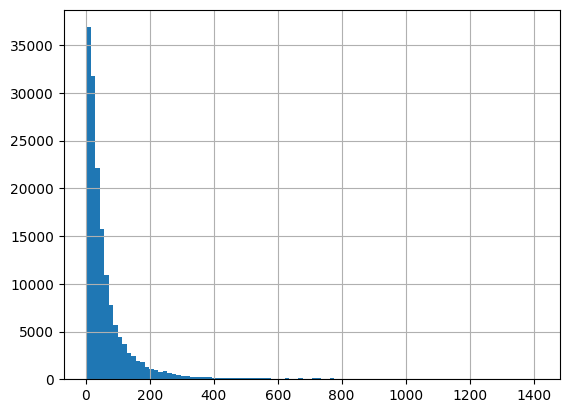

In [9]:
df_train["word_count"].hist(bins=100)

In [10]:
df_train["word_count"].describe(percentiles=[0.9, 0.95, 0.99,])

count    159571.000000
mean         67.273527
std          99.230702
min           1.000000
50%          36.000000
90%         152.000000
95%         230.000000
99%         567.000000
max        1411.000000
Name: word_count, dtype: float64

In [11]:
for max_word_count in [256, 512, 1024]:
    print(f"Word count: {max_word_count} --> percentile: {(df_train['word_count'] <= max_word_count).sum() / len(df_train):.2%}")

Word count: 256 --> percentile: 95.95%
Word count: 512 --> percentile: 98.76%
Word count: 1024 --> percentile: 99.98%


In [12]:
df_train.drop(columns=["word_count"], inplace=True)

Word count will be truncated to a limit of 256, 512 or 1024 words (as powers of 2), depending on the balance between precision/training time/RAM needs, which will be decided later. In any case, with these words limits, most of the cases (>95%) are covered.

# Preprocessing

## Stratification

In [13]:
for col in df_train.columns[2:-1]:
    print(df_train[col].value_counts(normalize=True))

toxic
0    0.904156
1    0.095844
Name: proportion, dtype: float64
severe_toxic
0    0.990004
1    0.009996
Name: proportion, dtype: float64
obscene
0    0.947052
1    0.052948
Name: proportion, dtype: float64
threat
0    0.997004
1    0.002996
Name: proportion, dtype: float64
insult
0    0.950636
1    0.049364
Name: proportion, dtype: float64


As showed above, the distribution of classes is highly unbalanced (many more 0s than 1s), but also very distant from one to another (toxic showing 10% positives but identity_hate less than 1%).

This makes mandatory to use a multi-label stratified KFold, as if we'd use a standard one, there is high chance than some folds wouldn't include any positive class from the less frequent labels.

In [14]:
X_idx = df_train.index.values
X_idx

array([     0,      1,      2, ..., 159568, 159569, 159570])

In [15]:
y = df_train.iloc[:, 2:-1].values
y

array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

In [16]:
kfold = IterativeStratification(n_splits=5, order=1)

In [17]:
df_train["fold"] = -1
for fold, (train_idx, val_idx) in enumerate(kfold.split(X_idx, y)):
    df_train.loc[val_idx, "fold"] = fold
df_train.insert(1, "fold", df_train.pop("fold"))

In [18]:
df_train.sample(10)

,id,fold,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
81660,da706d3432409139,1,"I do think so, yes, on both points (Latin loan...",0,0,0,0,0,0
91196,f3e82ae6a0ce4a78,3,"""\n\nI had attempted to get a response on thei...",0,0,0,0,0,0
980,02ae218e901a58f0,2,"""\nOkay, but only if they are truly not needed...",0,0,0,0,0,0
2919,07e1c4058476e215,1,"blocked me accusing me for trolling. If he, yo...",0,0,0,0,0,0
7785,14b82142bd070ee2,2,user:ihaveapickle user:208.113.241.125 \nI d...,0,0,0,0,0,0
59598,9f9681b20f5bcff5,2,"LOL, That will be awesome to have to track dow...",0,0,0,0,0,0
15777,29a9366263aa98cf,0,But Hebephiles *are* Pedophiles if the object ...,0,0,0,0,0,0
120971,8736456a53775afe,0,"""\n The issue originally was the word change, ...",0,0,0,0,0,0
46760,7cf44f6031c506d4,3,"(actually, they're also showing signs that Nor...",0,0,0,0,0,0
90580,f25be3b332006499,0,"We quote what the police have said, not what y...",0,0,0,0,0,0


In [19]:
# Check that the folds were distributed evenly
df_train["fold"].value_counts(normalize=True)

fold
3    0.200005
0    0.200005
2    0.200005
4    0.200005
1    0.199980
Name: proportion, dtype: float64

In [20]:
label_cols = df_train.columns[3:]
label_cols

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [21]:
# Check that within each fold, the proportions of labels are the same as in the full dataset
check_proportions = pd.DataFrame([df_train[label_cols].mean().round(4)], index=["full dataset"])
check_proportions.index.name = "fold"
check_proportions = pd.concat([check_proportions, df_train.groupby("fold")[label_cols].mean().round(4)])
check_proportions.rename(columns=lambda x: f"proportion_{x}", inplace=True)
check_proportions

,proportion_toxic,proportion_severe_toxic,proportion_obscene,proportion_threat,proportion_insult,proportion_identity_hate
fold,,,,,,
full dataset,0.0958,0.0100,0.0529,0.0030,0.0494,0.0088
0,0.0958,0.0097,0.0530,0.0029,0.0493,0.0086
1,0.0959,0.0099,0.0530,0.0033,0.0494,0.0086
2,0.0958,0.0103,0.0529,0.0030,0.0493,0.0083
3,0.0958,0.0097,0.0530,0.0029,0.0493,0.0088
4,0.0958,0.0103,0.0530,0.0029,0.0494,0.0097


Checked that all the folds have the same number of samples, and the proportion of classes for each label is approximately the same than in the full dataset.

## Tokenization

In [22]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/home/azureuser/ruben/toxicity_classificator/.venv/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
def tokenize(batch):
    return tokenizer(batch["comment_text"], padding="max_length", truncation=True, max_length=MAX_LENGTH)

In [24]:
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
def add_label_vector(batch):
    batch["labels"] = [list(row) for row in zip(*[batch[col] for col in label_cols])]
    batch["labels"] = np.array(batch["labels"], dtype=np.float32)
    return batch

In [25]:
if not os.path.exists(PATH_DS_TOKENIZED):
    ds_raw = Dataset.from_pandas(df_train)
    ds_raw = ds_raw.map(add_label_vector, batched=True)
    ds_tokenized = ds_raw.map(tokenize, batched=True, remove_columns=["comment_text"]+label_cols)
    ds_tokenized.save_to_disk(PATH_DS_TOKENIZED)

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Map:   0%|          | 0/159571 [00:00<?, ? examples/s]

Saving the dataset (0/2 shards):   0%|          | 0/159571 [00:00<?, ? examples/s]

# Model training

In [26]:
def get_fold_datasets(ds, fold):
    ds_train = ds.filter(lambda x: x["fold"] != fold)
    ds_val = ds.filter(lambda x: x["fold"] == fold)
    return ds_train, ds_val

In [27]:
def model_init(model_name=MODEL):
    return AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=6,
        problem_type="multi_label_classification",
    )

In [28]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    auc = roc_auc_score(labels, probs, average="macro")
    return {"roc_auc_macro": auc}

In [29]:
ds_tokenized = load_from_disk(PATH_DS_TOKENIZED)
ds_tokenized

for fold in range(5):

    path_output_dir = os.path.join(PATH_OUTPUT_DIR, f"fold_{fold}")
    if not os.path.exists(path_output_dir):
        os.makedirs(path_output_dir, exist_ok=True)
    path_output_model = os.path.join(path_output_dir, "model_final")


    train, val = get_fold_datasets(ds_tokenized, fold)
    print("-"*100)
    print(f"|{' '*98}|")
    print(f"|{' '*20}FOLD {fold}: TRAIN SIZE: {len(train)} ({len(train)/len(ds_tokenized):.2%}), VAL SIZE: {len(val)} ({len(val)/len(ds_tokenized):.2%}){' '*18}|")
    print(f"|{' '*98}|")
    print("-"*100)

    args = TrainingArguments(
        # Training structure parameters
        num_train_epochs=3,
        per_device_train_batch_size=32,     # Try to use multiples of 8 for maximum GPU efficiency
        gradient_accumulation_steps=1,
        per_device_eval_batch_size=32,      # Try to use multiples of 8 for maximum GPU efficiency
        # Optimization parameters
        learning_rate=1e-5,
        weight_decay=0.01,
        optim="adamw_torch_fused",
        # Evaluation and saving parameters
        evaluation_strategy="steps",
        save_strategy="steps",
        eval_steps=2048,                    # Try to use a multiple of the batch size so the evaluation is made on an integer number of full batches
        save_steps=2048,                    # Try to use a multiple of the batch size so the evaluation is made on an integer number of full batches
        load_best_model_at_end=True,
        metric_for_best_model="roc_auc_macro",
        # Precision and memory parameters
        fp16=True,
        gradient_checkpointing=False,
        dataloader_num_workers=2,
        dataloader_pin_memory=True,
        # Logging and reproducibility parameters
        logging_steps=50,
        seed=RANDOM_SEED,
        output_dir= path_output_dir,
    )

    trainer = Trainer(
        model=model_init(MODEL),
        args=args,
        train_dataset=train,
        eval_dataset=val,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    )

    trainer.train()

    trainer.save_model(path_output_model)

Filter:   0%|          | 0/159571 [00:00<?, ? examples/s]

Filter:   0%|          | 0/159571 [00:00<?, ? examples/s]

----------------------------------------------------------------------------------------------------
|                                                                                                  |
|                    FOLD 0: TRAIN SIZE: 127656 (80.00%), VAL SIZE: 31915 (20.00%)                  |
|                                                                                                  |
----------------------------------------------------------------------------------------------------


/home/azureuser/ruben/toxicity_classificator/.venv/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked

OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 15.57 GiB of which 45.38 MiB is free. Including non-PyTorch memory, this process has 15.53 GiB memory in use. Of the allocated memory 15.32 GiB is allocated by PyTorch, and 78.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)